In [4]:
import os
import torch
from glob import glob 

from torch.utils import data
from pytorch_ssn.model.SSN import SSN, crop_like, superpixel_flow
from pytorch_ssn.model.util import get_spixel_image

import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import pytorch_ssn.IO as IO
from pytorch_ssn.connectivity import enforce_connectivity


from utils.optical_flow import computedepth, computeflow
from pytorch_ssn.RAFT.core.raft import RAFT
from pytorch_ssn.model.ResUnet import ResUnet

os.environ['CUDA_VISIBLE_DEVICES']='0'
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)


cuda


In [2]:
# Helper Functions

class ARGS:
    def __init__(self):
        self.n_spixels=100
        self.num_steps=10
        self.result_dir='./results/pix/'
        self.pre_dir='./pytorch_ssn/model/slic_model/45000_0.527_model.pt'        
        self.root = 'data'
args = ARGS()


def imgtensor2np(img):
    return img.permute(1,2,0).detach().cpu().numpy()
def to_device(args, device):
    args_out = []
    for arg in args:
        if isinstance(arg, list):
            arg = [ elem.to(device) for elem in arg ]
        else:
            arg = arg.to(device)
        args_out.append(arg)
    return args_out


def connect_segments(new_spix_indices, num_h, num_w, h, w):
    new_spix_indices = new_spix_indices[0]
    new_spix_indices = new_spix_indices[:, :h, :w].contiguous()
    spix_index = new_spix_indices.cpu().numpy()[0]
    spix_index = spix_index.astype(int)

    segment_size = (h * w) / (int(num_h*num_w) * 1.0)
    min_size = int(0.06 * segment_size)
    max_size = int(3 * segment_size)
    spix_index = enforce_connectivity(spix_index[np.newaxis, :, :], min_size, max_size)[0]
    spix_index = torch.tensor(spix_index).unsqueeze(0).unsqueeze(0).to(device)
    return spix_index

def segmentfromLabels(given_img, new_spix_indices, num_h,num_w, connect=False):
    h, w = given_img.shape[0], given_img.shape[1]
    new_spix_indices = new_spix_indices[:, :h, :w].contiguous()
    spix_index = new_spix_indices.cpu().numpy()[0]
    spix_index = spix_index.astype(int)

    if connect:
        segment_size = (given_img.shape[0] * given_img.shape[1]) / (int(num_h*num_w) * 1.0)
        min_size = int(0.06 * segment_size)
        max_size = int(3 * segment_size)
        spix_index = enforce_connectivity(spix_index[np.newaxis, :, :], min_size, max_size)[0]

    return  get_spixel_image(given_img, spix_index)


# [SETUP] - Raft model and SLIC
class MODELARGS:
    def __init__(self):
        # self.model = "./pytorch_ssn/model/flow_model/raft-kitti.pth"
        self.model = "./checkpoints/7_tartan.pth"    
        self.small= False; self.mixed_precision = True; 
        self.alternate_corr=False; self.dropout = 0
modelargs = MODELARGS()

# slic layer
SSNLayer = SSN(None, spixel_size=(5,5),dtype = 'layer', device = device)
# flow network
flownet = torch.nn.DataParallel(RAFT(modelargs))
flownet.load_state_dict(torch.load(modelargs.model))
flownet = flownet.module.to(device)
print(f"Flownet size: {flownet.count_parameters()}")

unet = torch.nn.DataParallel(ResUnet())
unet = unet.module.to(device)
print(f"UNet size: {unet.count_parameters()}")

no model
Flownet size: 5257536
UNet size: 2914083


# Sintel

In [ ]:
from skimage.color import rgb2lab
from skimage.util import img_as_float
from skimage import io
from pytorch_ssn.dataset import Resize, ssn_preprocess
from pytorch_ssn.RAFT.core.utils.utils import InputPadder, forward_interpolate


# [SINTEL TEST]

class DataTemplate(data.Dataset):
    def __init__(self, root = "/home/gokul/courses/CMSC828I/sinteldata/MPI-Sintel-complete", mode = 'training',folder = 'alley_2', shape = (128,256)):
        
        # self.imfiles = sorted(glob(root + f'/images/{mode}/*.jpg')); self.gtfiles = sorted(glob(root + f'/groundTruth/{mode}/*.mat'))
        self.imfiles = sorted(glob(root + f'/{mode}/clean/{folder}/*.png' ))
        self.flofiles = sorted(glob(root +f'/{mode}/flow/{folder}/*.flo') )
        assert len(self.imfiles)-1 == len(self.flofiles), f' {len(self.imfiles), len(self.flofiles)-1}'
        self.resize = Resize(shape)

    def __getitem__(self, i):
        # load image and GT segment
        imfile1,imfile2, flofile = self.imfiles[i],self.imfiles[i+1], self.flofiles[i]        
        im1,im2, flo = img_as_float(io.imread(imfile1)), img_as_float(io.imread(imfile2)), IO.read(flofile)
        im1,im2, flo = self.resize(im1, im1.shape[:2]),self.resize(im2, im2.shape[:2]), self.resize(flo, flo.shape[:2])
        h,w = im1.shape[:2]

        k = int(0.5 * (h*w)//25 )
        ssn_inputs, ssn_args = ssn_preprocess(rgb2lab(im1), None, k )
        im1 = np.transpose(im1, [2, 0, 1]).astype(np.float32)
        im2 = np.transpose(im2, [2, 0, 1]).astype(np.float32)
        flo = np.transpose(flo, [2, 0, 1]).astype(np.float32)
        return [im1, im2], flo, ssn_inputs, ssn_args

    def __len__(self):
        return len(self.flofiles)

dataset = DataTemplate()
dataloader= data.DataLoader(dataset,batch_size=1, shuffle=False, num_workers=1)

args.savefolder = 'sintelsegflow'
IO.foldercheck(f'{args.savefolder}/gt')
IO.foldercheck(f'{args.savefolder}/pred')

from loss import EPE

net.eval()
epe = []
for idx, data_sample in tqdm(enumerate(dataloader)):
    [im1, im2], flow, ssn_input, ssn_params = data_sample
    im1, im2, flow = to_device([im1, im2, flow], device)

    padder = InputPadder(im1.shape, mode='sintel')
    input1, input2 = padder.pad(im1, im2)

    flow_low, flow_pr = net(input1, input2, iters=24, test_mode=True)
    # epe.append(EPE(flow_pr, flow).item())

    ssn_input = ssn_input.to(device)  
    ssn_params = to_device(ssn_params, device)
    ssn_params.extend([None])
    _, spix_indices = SSNLayer(ssn_input, ssn_params)    

    spix_indices = crop_like(spix_indices.unsqueeze(1), im1)
    segflow_GT, _ = superpixel_flow( flow.clone(), spix_indices)
    segflow_pred, _ = superpixel_flow( flow_pr.clone(), spix_indices)    
    
    
    epe.append(EPE(segflow_pred, flow).item())
    break

    # flowrgb_GT = IO.visualize_flow( imgtensor2np(segflow_GT[0]) ) 
    # flowrgb_pred = IO.visualize_flow(imgtensor2np(flow_pr[0]))
    # cv2.imwrite(f'{args.savefolder}/gt/{str(idx).zfill(2)}.png', flowrgb_GT)
    # cv2.imwrite(f'{args.savefolder}/pred/{str(idx).zfill(2)}.png', flowrgb_pred)



In [ ]:
# EPE predicted flow
np.mean(epe)

In [ ]:
# EPE segmented flow
np.mean(epe)

#  Tartan

In [ ]:
from tartandataloader import TartanLoader 
from torch.utils.data import DataLoader
from loss import EPE, depthErrors

valset = TartanLoader(basepath = ['Data/office2'], mode = 'test05', scale = 2)
val_loader = DataLoader(valset, batch_size=1, shuffle=False, num_workers=4)


In [28]:
EPEs, EPEseg = [], []
means = []
net.eval()
for idx , sample in tqdm(enumerate(val_loader)):
    im0, im1, flow, flow_inliers, depth_gt, tr_gt, rot_gt, intrinsics, = to_device(sample[:-2], device)

    flow_low, flow_pr = net(im0, im1, iters=24, test_mode=True)

    ssn_input = sample[-2].to(device)  
    ssn_params = to_device(sample[-1], device)
    ssn_params.extend([None])

    _, spix_indices = SSNLayer(ssn_input, ssn_params) 
    spix_indices = crop_like(spix_indices.unsqueeze(1), im1)
    spix_indices = connect_segments(spix_indices, ssn_params[0], ssn_params[1], im0.shape[-2], im0.shape[-1])
    
    segflow_GT, _ = superpixel_flow( flow.clone(), spix_indices)        
    segflow_pred, _ = superpixel_flow( flow_pr.clone(), spix_indices)   


    depth_pred = computedepth([tr_gt, rot_gt, intrinsics, flow_pr], device) # use any flow function    
    means.append([torch.mean(depth_pred).item(), torch.mean(depth_gt).item()])
    
    gtdepthmap, pred_depthmap = imgtensor2np(depth_gt[0]).squeeze(), imgtensor2np(depth_pred[0]).squeeze()
    mask = np.logical_and(gtdepthmap > 0, gtdepthmap < 100)

    errors = depthErrors(gtdepthmap[mask], pred_depthmap[mask])
    EPEseg.append(EPE(segflow_pred, segflow_GT).item())
    EPEs.append(EPE(flow_pr, flow).item())
    break


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f60f896a4e0>>
Traceback (most recent call last):
  File "/home/gokul/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/gokul/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.6/multiprocessing/process.py", line 134, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
0it [00:00, ?it/s]Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f60f896a4e0>>
Traceback (most recent call last):
  File "/home/gokul/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 1328, in 

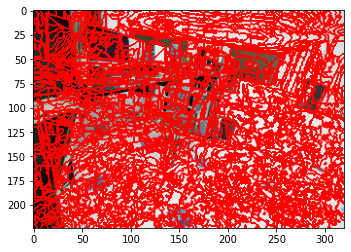

In [30]:
# VISUALIZING OVERSEGMENTED IMAGE
given_img = imgtensor2np(im0[0]).astype(np.uint8) 
segmented_img = segmentfromLabels(given_img, spix_indices[0], ssn_params[0],ssn_params[1], connect=True)
plt.imshow(segmented_img)

In [ ]:

# [UNCOMMENT TO VISUALIZE SEGMENTED OPTICAL FLOW]
flowrgb_GT = IO.visualize_flow( imgtensor2np(segflow_GT[0]) ) 
flowrgb_pred = IO.visualize_flow(imgtensor2np(segflow_pred[0]))


## [UNCOMMENT TO VISUALIZE Regular OPTICAL FLOW]
# flowrgb_GT = IO.visualize_flow( imgtensor2np(flow[0]) ) 
# flowrgb_pred = IO.visualize_flow(imgtensor2np(flow_pr[0]))

f, plts = plt.subplots(1,2,figsize=(10,10))
plts[0].imshow(flowrgb_GT)
plts[1].imshow(flowrgb_pred)

In [ ]:
f, plts = plt.subplots(1,2,figsize=(10,10))
plts[0].imshow(gtdepthmap)
plts[1].imshow(pred_depthmap)


# Binary Segmentation pipeline
 

In [5]:
from davisdataloader import DAVISSegmentationLoader
valset = DAVISSegmentationLoader(mode = "val")
trainset = DAVISSegmentationLoader(mode = "train")
val_loader= data.DataLoader(valset,batch_size=3, shuffle=False, num_workers=1)
train_loader= data.DataLoader(trainset,batch_size=3, shuffle=False, num_workers=1)

from loss import BCEDiceLoss
lossfn = BCEDiceLoss()

In [6]:
flownet.eval()
unet.train()
iterator = tqdm(enumerate(train_loader))
for i, sample in iterator:
    im1, im2, _, gt2 = to_device(sample[:-2], device)    
    
    # generate flow
    flow_preds = flownet(im1, im2, iters=24, test_mode=True)

    # generate super pixel features
    ssn_input = sample[-2].to(device)  
    ssn_params = to_device(sample[-1], device)
    ssn_params.extend([None])
    slic_features, spix_indices = SSNLayer(ssn_input, ssn_params) 
    slic_features = crop_like(slic_features, im1)
    # spix_indices = connect_segments(spix_indices, ssn_params[0], ssn_params[1], im0.shape[-2], im0.shape[-1])

    seginput = torch.cat((flow_preds[-1], slic_features), dim=1)
    seg_pred = unet(seginput)
    loss = lossfn(seg_pred, gt2)

    

2it [00:20, 10.19s/it]


KeyboardInterrupt: 

In [6]:
seg_pred.shape, gt2.shape

(torch.Size([1, 1, 256, 256]), torch.Size([1, 1, 256, 256]))

In [7]:


.item()

tensor(1.6806, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)